# Dataset

 - `utils.get_dataset`

$$
u = u(t, x)
$$

$$
\begin{aligned}
    & \frac{\partial u}{\partial t} + c\frac{\partial u}{\partial x} = 0,\quad t\in[0,1],\ x\in (0, 2\pi),\\
    & u(0,x) = g(x), \quad x\in(0, 2\pi) \\\\
    & c=80, \quad g(x) = \sin(x)
\end{aligned}
$$

- periodic BC

    - $u(t, 0) = u(t, 2\pi)$
    - $P_x = 2\pi \rightarrow w_x = 2\pi/P_x = 1$

In [1]:
from utils import get_dataset

In [2]:
u_ref, t_star, x_star = get_dataset()

In [3]:
print(u_ref.shape)
print(t_star.shape)
print(x_star.shape)

(200, 128)
(200,)
(128,)


# Data visualization

In [4]:
import jax.numpy as jnp
import matplotlib.pyplot as plt

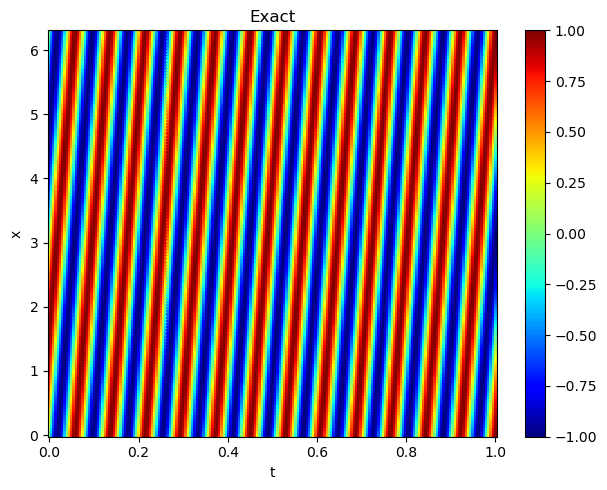

In [5]:
TT, XX = jnp.meshgrid(t_star, x_star, indexing="ij")

fig = plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.pcolor(TT, XX, u_ref, cmap="jet")
plt.colorbar()
plt.xlabel("t")
plt.ylabel("x")
plt.title("Exact")
plt.tight_layout()

# Model

In [6]:
import jax.numpy as jnp

from jaxpi.models import ForwardIVP

In [7]:
class Advection(ForwardIVP):
    def __init__(self, config):
        super().__init__(config)

    def u_net(self, params, t, x):
        z = jnp.stack([t, x])
        u = self.state.apply_fn(params, z)
        return u

In [8]:
workdir = "."
from configs import plain
config = plain.get_config()

import os
from jaxpi.utils import save_checkpoint, restore_checkpoint

In [9]:
model = Advection(config)

ckpt_path = os.path.abspath(os.path.join(workdir, "ckpt_pre", config.wandb.name))
save_checkpoint(model.state, ckpt_path, keep=config.saving.num_keep_ckpts, overwrite=True)
model.state = restore_checkpoint(model.state, ckpt_path)
params = model.state.params

In [10]:
u_ref, t_star, x_star = get_dataset()

u = model.u_net(params, t_star[0], x_star[0])
print(u.shape)
print(u)

(1,)
[-0.13589495]


In [11]:
class Advection(ForwardIVP):
    def __init__(self, config):
        super().__init__(config)

    def u_net(self, params, t, x):
        z = jnp.stack([t, x])
        u = self.state.apply_fn(params, z)
        return u[0]

In [12]:
model = Advection(config)

ckpt_path = os.path.abspath(os.path.join(workdir, "ckpt_pre", config.wandb.name))
save_checkpoint(model.state, ckpt_path, keep=config.saving.num_keep_ckpts, overwrite=True)
model.state = restore_checkpoint(model.state, ckpt_path)
params = model.state.params

In [13]:
u_ref, t_star, x_star = get_dataset()

u = model.u_net(params, t_star[0], x_star[0])
print(u.shape)
print(u)

()
-0.13589495


In [14]:
from jax import vmap

In [15]:
class Advection(ForwardIVP):
    def __init__(self, config):
        super().__init__(config)

        # Predictions over a grid
        self.u_pred_fn = vmap(vmap(self.u_net, (None, None, 0)), (None, 0, None))
        self.u_pred_fn = vmap(vmap(self.u_net, (None, None, 0)), (None, 0, None))

    def u_net(self, params, t, x):
        z = jnp.stack([t, x])
        u = self.state.apply_fn(params, z)
        return u[0]

In [16]:
model = Advection(config)

ckpt_path = os.path.abspath(os.path.join(workdir, "ckpt_pre", config.wandb.name))
save_checkpoint(model.state, ckpt_path, keep=config.saving.num_keep_ckpts, overwrite=True)
model.state = restore_checkpoint(model.state, ckpt_path)
params = model.state.params

In [17]:
u_ref, t_star, x_star = get_dataset()

u_pred = model.u_pred_fn(params, t_star, x_star)
print(u_pred.shape)

(200, 128)


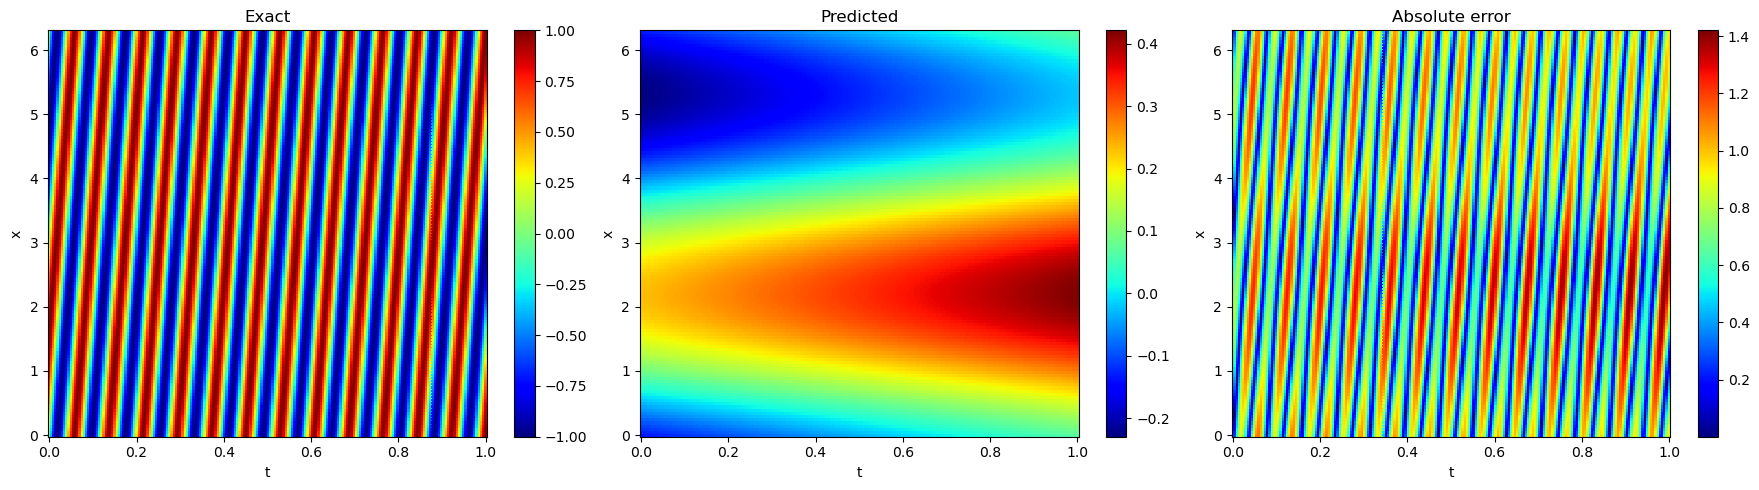

In [18]:
TT, XX = jnp.meshgrid(t_star, x_star, indexing="ij")

fig = plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.pcolor(TT, XX, u_ref, cmap="jet")
plt.colorbar()
plt.xlabel("t")
plt.ylabel("x")
plt.title("Exact")
plt.tight_layout()

plt.subplot(1, 3, 2)
plt.pcolor(TT, XX, u_pred, cmap="jet")
plt.colorbar()
plt.xlabel("t")
plt.ylabel("x")
plt.title("Predicted")
plt.tight_layout()

plt.subplot(1, 3, 3)
plt.pcolor(TT, XX, jnp.abs(u_ref - u_pred), cmap="jet")
plt.colorbar()
plt.xlabel("t")
plt.ylabel("x")
plt.title("Absolute error")
plt.tight_layout()

# Residual net

In [19]:
from functools import partial

import jax.numpy as jnp
from jax import jit, grad, vmap

from jaxpi.models import ForwardIVP

In [20]:
class Advection(ForwardIVP):
    def __init__(self, config, u0, t_star, x_star, c):
        super().__init__(config)

        self.u0 = u0
        self.t_star = t_star
        self.x_star = x_star
        self.c = c

        self.t0 = t_star[0]
        self.t1 = t_star[-1]

        # Predictions over a grid
        self.u_pred_fn = vmap(vmap(self.u_net, (None, None, 0)), (None, 0, None))
        self.r_pred_fn = vmap(vmap(self.r_net, (None, None, 0)), (None, 0, None))

    def u_net(self, params, t, x):
        z = jnp.stack([t, x])
        u = self.state.apply_fn(params, z)
        return u[0]
    
    def r_net(self, params, t, x):
        u = self.u_net(params, t, x)
        u_t = grad(self.u_net, argnums=1)(params, t, x)
        u_x = grad(self.u_net, argnums=2)(params, t, x)
        return u_t + self.c * u_x
    
    @partial(jit, static_argnums=(0,))
    def losses(self, params, batch):
        # Initial condition loss
        u_pred = vmap(self.u_net, (None, None, 0))(params, self.t0, self.x_star)
        ics_loss = jnp.mean((self.u0 - u_pred) ** 2)

        # Residual loss
        r_pred = vmap(self.r_net, (None, 0, 0))(params, batch[:, 0], batch[:, 1])
        res_loss = jnp.mean((r_pred) ** 2)

        loss_dict = {"ics": ics_loss, "res": res_loss}
        return loss_dict

In [21]:
# Get  dataset
u_ref, t_star, x_star = get_dataset()
c = 80

# Initial condition u(t-0, x)
u0 = u_ref[0, :]

# Initialize model
model = Advection(config, u0, t_star, x_star, c)

# Model parameters
ckpt_path = os.path.abspath(os.path.join(workdir, "ckpt_pre", config.wandb.name))
save_checkpoint(model.state, ckpt_path, keep=config.saving.num_keep_ckpts, overwrite=True)
model.state = restore_checkpoint(model.state, ckpt_path)
params = model.state.params

In [22]:
model.u_net(params, t_star[0], x_star[0])

Array(-0.13589495, dtype=float32)

In [23]:
model.r_net(params, t_star[0], x_star[0])

Array(15.047525, dtype=float32)

In [24]:
from jaxpi.samplers import UniformSampler

In [25]:
# Define domain
t0 = t_star[0]
t1 = t_star[-1]

x0 = x_star[0]
x1 = x_star[-1]

dom = jnp.array([[t0, t1],
                 [x0, x1]])

# Initialize residual sampler
res_sampler = iter(UniformSampler(dom, config.training.batch_size_per_device))

In [26]:
dom

Array([[0.       , 1.       ],
       [0.       , 6.2831855]], dtype=float32)

In [27]:
# Get a random batch
batch = next(res_sampler)

In [28]:
print(batch.shape)
print(batch)

(1, 4096, 2)
[[[0.41653895 1.4433756 ]
  [0.42941797 3.8569984 ]
  [0.8585658  5.3567786 ]
  ...
  [0.03447223 0.25723165]
  [0.17862046 2.1054366 ]
  [0.7942091  5.775389  ]]]


In [29]:
import jax
from jax.tree_util import tree_map

In [30]:
batch = jax.device_get(tree_map(lambda x: x[0], batch))

In [31]:
print(batch.shape)
print(batch)

(4096, 2)
[[0.41653895 1.4433756 ]
 [0.42941797 3.8569984 ]
 [0.8585658  5.3567786 ]
 ...
 [0.03447223 0.25723165]
 [0.17862046 2.1054366 ]
 [0.7942091  5.775389  ]]


In [32]:
model.losses(params, batch)

{'ics': Array(0.3372373, dtype=float32),
 'res': Array(161.13892, dtype=float32)}

In [33]:
from jax import jacrev
from jaxpi.utils import flatten_pytree

In [34]:
# Compute gradient of each loss with respect to network parameters
grads = jacrev(model.losses)(params, batch)

grad_dict = {}
for key, value in grads.items():
    flattened_grad = flatten_pytree(value)
    grad_dict[key] = flattened_grad

In [35]:
import seaborn as sns

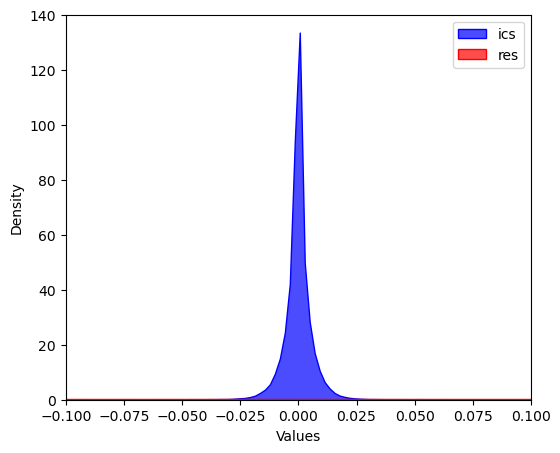

In [36]:
# Plot gradients as histograms
fig = plt.figure(figsize=(6, 5))

sns.kdeplot(grad_dict['ics'], fill=True, alpha=0.7, color='blue', label='ics')
sns.kdeplot(grad_dict['res'], fill=True, alpha=0.7, color='red', label='res')

plt.xlabel('Values')
plt.ylabel('Density')
plt.xlim([-0.1, 0.1])
plt.legend()
plt.show()

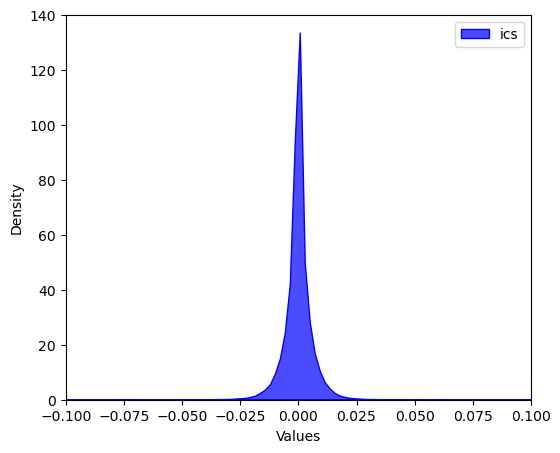

In [37]:
# Plot gradients as histograms
fig = plt.figure(figsize=(6, 5))

sns.kdeplot(grad_dict['ics'], fill=True, alpha=0.7, color='blue', label='ics')

plt.xlabel('Values')
plt.ylabel('Density')
plt.xlim([-0.1, 0.1])
plt.legend()
plt.show()

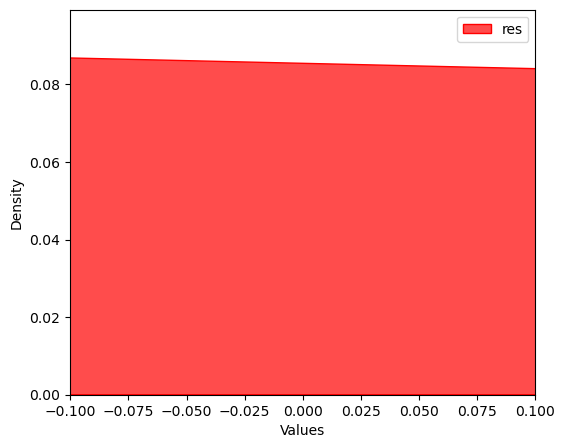

: 

In [38]:
# Plot gradients as histograms
fig = plt.figure(figsize=(6, 5))

sns.kdeplot(grad_dict['res'], fill=True, alpha=0.7, color='red', label='res')

plt.xlabel('Values')
plt.ylabel('Density')
plt.xlim([-0.1, 0.1])
plt.legend()
plt.show()

# Evaluator

In [39]:
from jaxpi.evaluator import BaseEvaluator

In [40]:
class AdvectionEvaluator(BaseEvaluator):
    def __init__(self, config, model):
        super().__init__(config, model)

In [41]:
 # Get  dataset
u_ref, t_star, x_star = get_dataset()
c = 80

# Initial condition
u0 = u_ref[0, :]

# Define domain
t0 = t_star[0]
t1 = t_star[-1]

x0 = x_star[0]
x1 = x_star[-1]

dom = jnp.array([[t0, t1], [x0, x1]])

# Initialize model
model = Advection(config, u0, t_star, x_star, c)
# Initialize residual sampler
res_sampler = iter(UniformSampler(dom, config.training.batch_size_per_device))

batch = next(res_sampler)

In [42]:
evaluator = AdvectionEvaluator(config, model)

In [43]:
# Get the first replica of the state and batch
state = jax.device_get(tree_map(lambda x: x[0], model.state))
batch = jax.device_get(tree_map(lambda x: x[0], batch))

In [44]:
state

TrainState(step=array(0, dtype=int32), apply_fn=<bound method Module.apply of Mlp(
    # attributes
    arch_name = 'Mlp'
    num_layers = 4
    hidden_dim = 256
    out_dim = 1
    activation = 'tanh'
    periodicity = axis: !!python/tuple
    - 1
    period: !!python/tuple
    - 1.0
    trainable: !!python/tuple
    - false
    
    fourier_emb = None
    reparam = None
)>, params={'params': {'Dense_0': {'bias': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [45]:
batch

array([[0.41653895, 1.4433756 ],
       [0.42941797, 3.8569984 ],
       [0.8585658 , 5.3567786 ],
       ...,
       [0.03447223, 0.25723165],
       [0.17862046, 2.1054366 ],
       [0.7942091 , 5.775389  ]], dtype=float32)

In [46]:
log_dict = evaluator(state, batch)

In [47]:
log_dict

{'ics_loss': Array(0.3372373, dtype=float32),
 'res_loss': Array(161.13892, dtype=float32),
 'ics_weight': array(1., dtype=float32),
 'res_weight': array(1., dtype=float32),
 'ics_grad_norm': Array(2.819168, dtype=float32),
 'res_grad_norm': Array(4989.8228, dtype=float32)}

In [48]:
batch = next(res_sampler)
model.state = model.step(model.state, batch)

In [49]:
state = jax.device_get(tree_map(lambda x: x[0], model.state))
batch = jax.device_get(tree_map(lambda x: x[0], batch))
log_dict = evaluator(state, batch)
log_dict

{'ics_loss': Array(1.2371542, dtype=float32),
 'res_loss': Array(1349.4805, dtype=float32),
 'ics_weight': array(1., dtype=float32),
 'res_weight': array(1., dtype=float32),
 'ics_grad_norm': Array(5.700795, dtype=float32),
 'res_grad_norm': Array(15157.352, dtype=float32)}

In [50]:
for step in range(2000):
    batch = next(res_sampler)
    model.state = model.step(model.state, batch)

In [51]:
state = jax.device_get(tree_map(lambda x: x[0], model.state))
batch = jax.device_get(tree_map(lambda x: x[0], batch))
log_dict = evaluator(state, batch)
log_dict

{'ics_loss': Array(0.4954335, dtype=float32),
 'res_loss': Array(0.00032599, dtype=float32),
 'ics_weight': array(1., dtype=float32),
 'res_weight': array(1., dtype=float32),
 'ics_grad_norm': Array(0.83024526, dtype=float32),
 'res_grad_norm': Array(1.0109117, dtype=float32)}

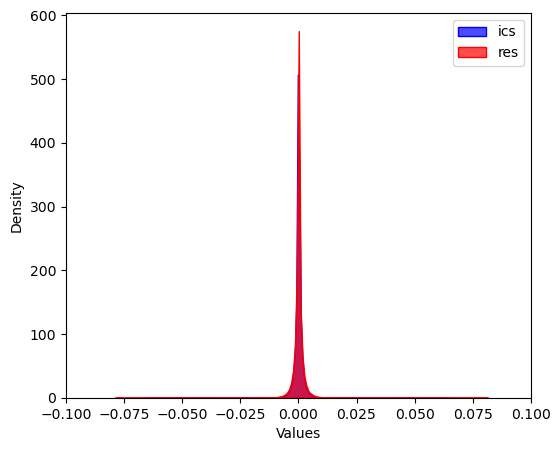

In [52]:
ckpt_path = os.path.abspath(os.path.join(workdir, "ckpt_pre", config.wandb.name))
save_checkpoint(model.state, ckpt_path, keep=config.saving.num_keep_ckpts, overwrite=True)
model.state = restore_checkpoint(model.state, ckpt_path)
params = model.state.params

grads = jacrev(model.losses)(params, batch)

grad_dict = {}
for key, value in grads.items():
    flattened_grad = flatten_pytree(value)
    grad_dict[key] = flattened_grad

fig = plt.figure(figsize=(6, 5))

sns.kdeplot(grad_dict['ics'], fill=True, alpha=0.7, color='blue', label='ics')
sns.kdeplot(grad_dict['res'], fill=True, alpha=0.7, color='red', label='res')

plt.xlabel('Values')
plt.ylabel('Density')
plt.xlim([-0.1, 0.1])
plt.legend()
plt.show()

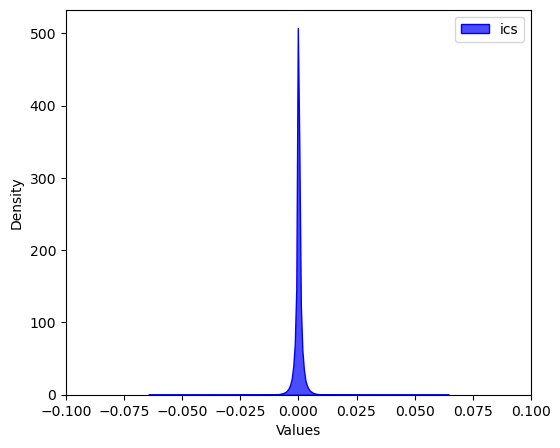

In [55]:
fig = plt.figure(figsize=(6, 5))

sns.kdeplot(grad_dict['ics'], fill=True, alpha=0.7, color='blue', label='ics')

plt.xlabel('Values')
plt.ylabel('Density')
plt.xlim([-0.1, 0.1])
plt.legend()
plt.show()

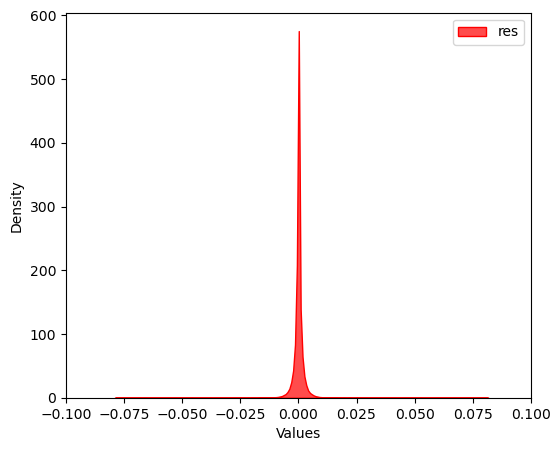

In [56]:
fig = plt.figure(figsize=(6, 5))

sns.kdeplot(grad_dict['res'], fill=True, alpha=0.7, color='red', label='res')

plt.xlabel('Values')
plt.ylabel('Density')
plt.xlim([-0.1, 0.1])
plt.legend()
plt.show()

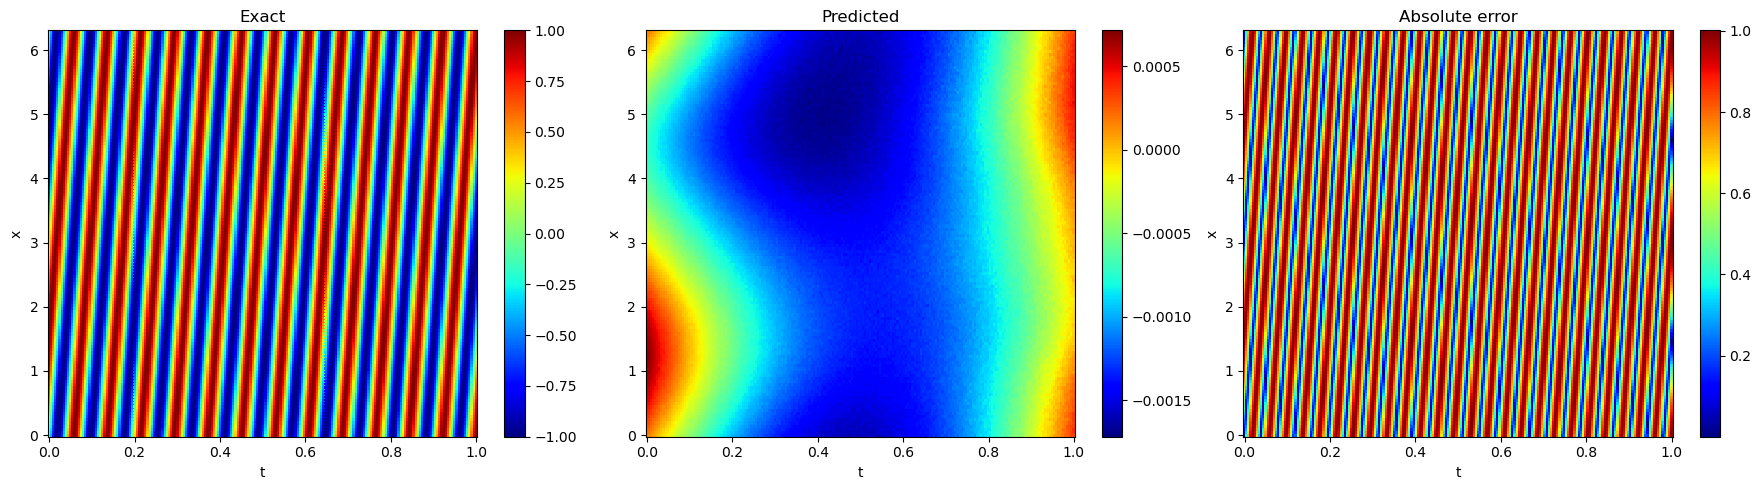

In [57]:
u_pred = model.u_pred_fn(params, t_star, x_star)
TT, XX = jnp.meshgrid(t_star, x_star, indexing="ij")

fig = plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.pcolor(TT, XX, u_ref, cmap="jet")
plt.colorbar()
plt.xlabel("t")
plt.ylabel("x")
plt.title("Exact")
plt.tight_layout()

plt.subplot(1, 3, 2)
plt.pcolor(TT, XX, u_pred, cmap="jet")
plt.colorbar()
plt.xlabel("t")
plt.ylabel("x")
plt.title("Predicted")
plt.tight_layout()

plt.subplot(1, 3, 3)
plt.pcolor(TT, XX, jnp.abs(u_ref - u_pred), cmap="jet")
plt.colorbar()
plt.xlabel("t")
plt.ylabel("x")
plt.title("Absolute error")
plt.tight_layout()

# Default config

In [70]:
from jax import lax

- PDE
$$
u = u(t, x)
$$

$$
\begin{aligned}
    & \frac{\partial u}{\partial t} + c\frac{\partial u}{\partial x} = 0,\quad t\in[0,1],\ x\in (0, 2\pi),\\
    & u(0,x) = g(x), \quad x\in(0, 2\pi) \\\\
    & c=80, \quad g(x) = \sin(x)
\end{aligned}
$$

- periodic BC
    - $u(t, 0) = u(t, 2\pi)$
    - $P_x = 2\pi \rightarrow w_x = 2\pi/P_x = 1$

- Trainable temporal periodicity
    - $u(0, x) = u(P_t, x)$
    - $P_t = 1 \rightarrow w_t = 2\pi/P_t = 2\pi$

- Fourier feature embeddings
    - `{"embed_scale": 1.0, "embed_dim": 256}`

- Weight factorization
    - `{"type": "weight_fact", "mean": 1.0, "stddev": 0.1}`

- Loss Balancing
    - Grad Norm Weighting

- Respect causality
    - Time-dependent PDE

In [71]:
class Advection(ForwardIVP):
    def __init__(self, config, u0, t_star, x_star, c):
        super().__init__(config)

        self.u0 = u0
        self.t_star = t_star
        self.x_star = x_star
        self.c = c

        self.t0 = t_star[0]
        self.t1 = t_star[-1]

        # Predictions over a grid
        self.u_pred_fn = vmap(vmap(self.u_net, (None, None, 0)), (None, 0, None))
        self.r_pred_fn = vmap(vmap(self.r_net, (None, None, 0)), (None, 0, None))

    def u_net(self, params, t, x):
        z = jnp.stack([t, x])
        u = self.state.apply_fn(params, z)
        return u[0]
    
    def r_net(self, params, t, x):
        u = self.u_net(params, t, x)
        u_t = grad(self.u_net, argnums=1)(params, t, x)
        u_x = grad(self.u_net, argnums=2)(params, t, x)
        return u_t + self.c * u_x
    
    @partial(jit, static_argnums=(0,))
    def losses(self, params, batch):
        # Initial condition loss
        u_pred = vmap(self.u_net, (None, None, 0))(params, self.t0, self.x_star)
        ics_loss = jnp.mean((self.u0 - u_pred) ** 2)

        # Residual loss
        if self.config.weighting.use_causal == True:
            l, w = self.res_and_w(params, batch)
            res_loss = jnp.mean(l * w)
        else:
            r_pred = vmap(self.r_net, (None, 0, 0))(params, batch[:, 0], batch[:, 1])
            res_loss = jnp.mean((r_pred) ** 2)

        loss_dict = {"ics": ics_loss, "res": res_loss}
        return loss_dict
    
    @partial(jit, static_argnums=(0,))
    def res_and_w(self, params, batch):
        # Sort temporal coordinates for computing  temporal weights
        t_sorted = batch[:, 0].sort()
        # Compute residuals over the full domain
        r_pred = vmap(self.r_net, (None, 0, 0))(params, t_sorted, batch[:, 1])
        # Split residuals into chunks
        r_pred = r_pred.reshape(self.num_chunks, -1)
        l = jnp.mean(r_pred**2, axis=1)
        # Compute temporal weights
        w = lax.stop_gradient(jnp.exp(-self.tol * (self.M @ l)))
        return l, w

In [72]:
workdir = "."
from configs import default
config = default.get_config()

u_ref, t_star, x_star = get_dataset()
c = 80
u0 = u_ref[0, :]
model = Advection(config, u0, t_star, x_star, c)

t0 = t_star[0]
t1 = t_star[-1]
x0 = x_star[0]
x1 = x_star[-1]
dom = jnp.array([[t0, t1], [x0, x1]])
res_sampler = iter(UniformSampler(dom, config.training.batch_size_per_device))

evaluator = AdvectionEvaluator(config, model)

In [73]:
ckpt_path = os.path.abspath(os.path.join(workdir, "ckpt_pre", config.wandb.name))
save_checkpoint(model.state, ckpt_path, keep=config.saving.num_keep_ckpts, overwrite=True)
model.state = restore_checkpoint(model.state, ckpt_path)
params = model.state.params

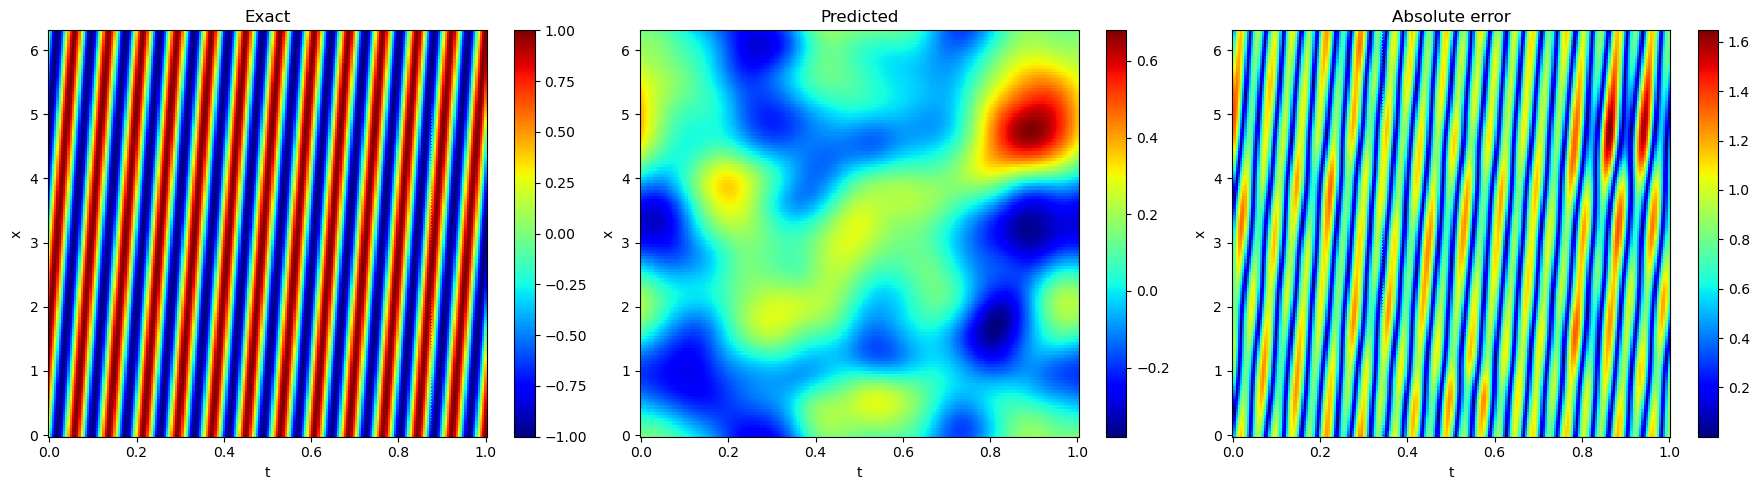

In [74]:
u_pred = model.u_pred_fn(params, t_star, x_star)
TT, XX = jnp.meshgrid(t_star, x_star, indexing="ij")

fig = plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.pcolor(TT, XX, u_ref, cmap="jet")
plt.colorbar()
plt.xlabel("t")
plt.ylabel("x")
plt.title("Exact")
plt.tight_layout()

plt.subplot(1, 3, 2)
plt.pcolor(TT, XX, u_pred, cmap="jet")
plt.colorbar()
plt.xlabel("t")
plt.ylabel("x")
plt.title("Predicted")
plt.tight_layout()

plt.subplot(1, 3, 3)
plt.pcolor(TT, XX, jnp.abs(u_ref - u_pred), cmap="jet")
plt.colorbar()
plt.xlabel("t")
plt.ylabel("x")
plt.title("Absolute error")
plt.tight_layout()

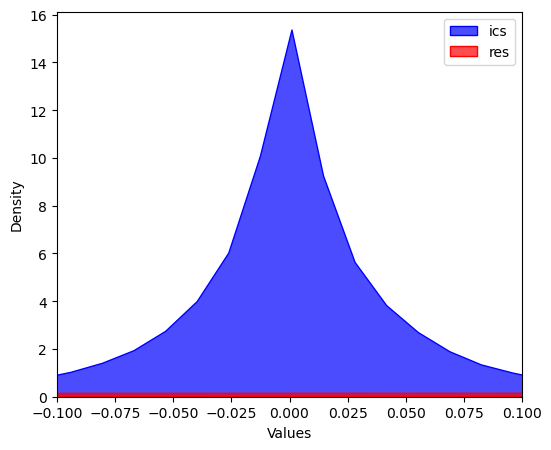

In [75]:
batch = next(res_sampler)
batch = jax.device_get(tree_map(lambda x: x[0], batch))

grads = jacrev(model.losses)(params, batch)

grad_dict = {}
for key, value in grads.items():
    flattened_grad = flatten_pytree(value)
    grad_dict[key] = flattened_grad

fig = plt.figure(figsize=(6, 5))

sns.kdeplot(grad_dict['ics'], fill=True, alpha=0.7, color='blue', label='ics')
sns.kdeplot(grad_dict['res'], fill=True, alpha=0.7, color='red', label='res')

plt.xlabel('Values')
plt.ylabel('Density')
plt.xlim([-0.1, 0.1])
plt.legend()
plt.show()

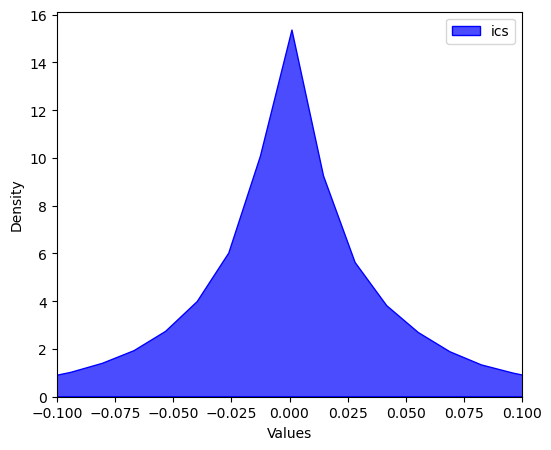

In [76]:
fig = plt.figure(figsize=(6, 5))

sns.kdeplot(grad_dict['ics'], fill=True, alpha=0.7, color='blue', label='ics')

plt.xlabel('Values')
plt.ylabel('Density')
plt.xlim([-0.1, 0.1])
plt.legend()
plt.show()

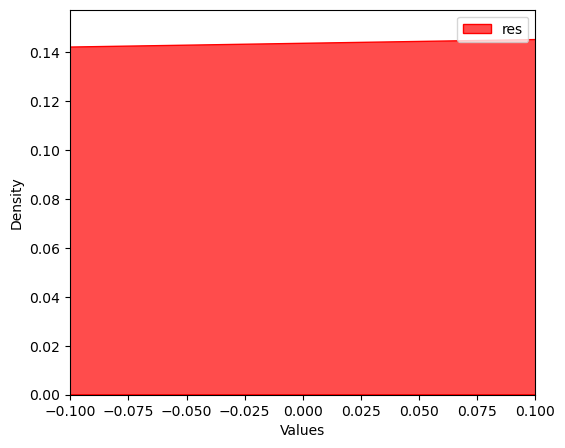

In [77]:
fig = plt.figure(figsize=(6, 5))

sns.kdeplot(grad_dict['res'], fill=True, alpha=0.7, color='red', label='res')

plt.xlabel('Values')
plt.ylabel('Density')
plt.xlim([-0.1, 0.1])
plt.legend()
plt.show()

In [78]:
workdir = "."
from configs import default
config = default.get_config()

u_ref, t_star, x_star = get_dataset()
c = 80
u0 = u_ref[0, :]
model = Advection(config, u0, t_star, x_star, c)

t0 = t_star[0]
t1 = t_star[-1]
x0 = x_star[0]
x1 = x_star[-1]
dom = jnp.array([[t0, t1], [x0, x1]])
res_sampler = iter(UniformSampler(dom, config.training.batch_size_per_device))

evaluator = AdvectionEvaluator(config, model)

In [79]:
batch = next(res_sampler)
model.state = model.step(model.state, batch)
state = jax.device_get(tree_map(lambda x: x[0], model.state))
batch = jax.device_get(tree_map(lambda x: x[0], batch))
log_dict = evaluator(state, batch)
log_dict

{'ics_loss': Array(3.6483712, dtype=float32),
 'res_loss': Array(2552.3223, dtype=float32),
 'ics_weight': array(1., dtype=float32),
 'res_weight': array(1., dtype=float32),
 'ics_grad_norm': Array(70.08806, dtype=float32),
 'res_grad_norm': Array(36726.59, dtype=float32)}

In [80]:
for step in range(2000):
    batch = next(res_sampler)
    model.state = model.step(model.state, batch)
    if step % 100 == 0:
        model.state = model.update_weights(model.state, batch)

In [81]:
batch = next(res_sampler)
model.state = model.step(model.state, batch)
state = jax.device_get(tree_map(lambda x: x[0], model.state))
batch = jax.device_get(tree_map(lambda x: x[0], batch))
log_dict = evaluator(state, batch)
log_dict

{'ics_loss': Array(0.01043333, dtype=float32),
 'res_loss': Array(0.3778537, dtype=float32),
 'ics_weight': array(8.484644, dtype=float32),
 'res_weight': array(0.6168428, dtype=float32),
 'ics_grad_norm': Array(4.7840776, dtype=float32),
 'res_grad_norm': Array(131.48404, dtype=float32)}

In [82]:
ckpt_path = os.path.abspath(os.path.join(workdir, "ckpt_pre", config.wandb.name))
save_checkpoint(model.state, ckpt_path, keep=config.saving.num_keep_ckpts, overwrite=True)
model.state = restore_checkpoint(model.state, ckpt_path)
params = model.state.params

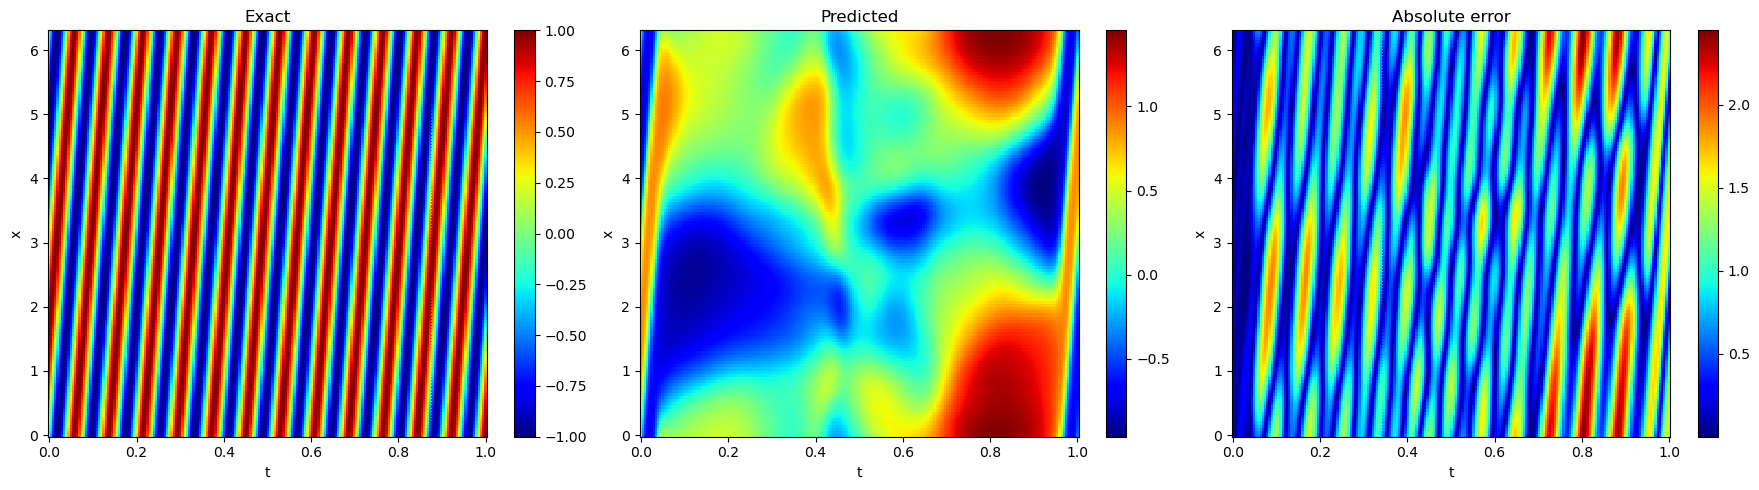

In [83]:
u_pred = model.u_pred_fn(params, t_star, x_star)
TT, XX = jnp.meshgrid(t_star, x_star, indexing="ij")

fig = plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.pcolor(TT, XX, u_ref, cmap="jet")
plt.colorbar()
plt.xlabel("t")
plt.ylabel("x")
plt.title("Exact")
plt.tight_layout()

plt.subplot(1, 3, 2)
plt.pcolor(TT, XX, u_pred, cmap="jet")
plt.colorbar()
plt.xlabel("t")
plt.ylabel("x")
plt.title("Predicted")
plt.tight_layout()

plt.subplot(1, 3, 3)
plt.pcolor(TT, XX, jnp.abs(u_ref - u_pred), cmap="jet")
plt.colorbar()
plt.xlabel("t")
plt.ylabel("x")
plt.title("Absolute error")
plt.tight_layout()

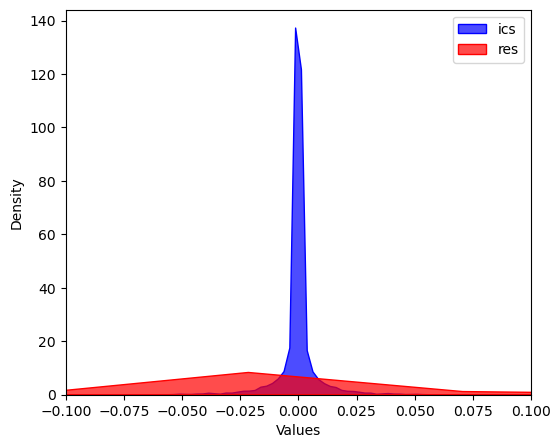

In [84]:
batch = next(res_sampler)
batch = jax.device_get(tree_map(lambda x: x[0], batch))

grads = jacrev(model.losses)(params, batch)

grad_dict = {}
for key, value in grads.items():
    flattened_grad = flatten_pytree(value)
    grad_dict[key] = flattened_grad

fig = plt.figure(figsize=(6, 5))

sns.kdeplot(grad_dict['ics'], fill=True, alpha=0.7, color='blue', label='ics')
sns.kdeplot(grad_dict['res'], fill=True, alpha=0.7, color='red', label='res')

plt.xlabel('Values')
plt.ylabel('Density')
plt.xlim([-0.1, 0.1])
plt.legend()
plt.show()

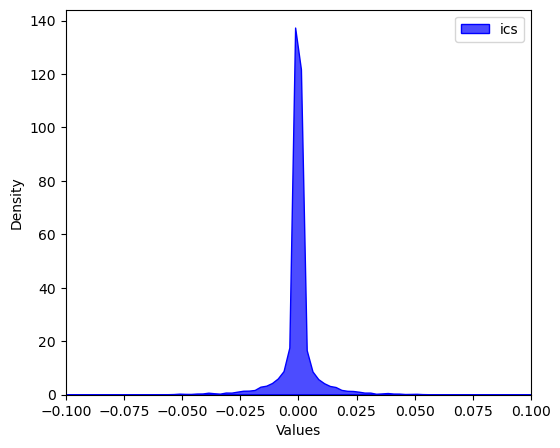

In [85]:
fig = plt.figure(figsize=(6, 5))

sns.kdeplot(grad_dict['ics'], fill=True, alpha=0.7, color='blue', label='ics')

plt.xlabel('Values')
plt.ylabel('Density')
plt.xlim([-0.1, 0.1])
plt.legend()
plt.show()

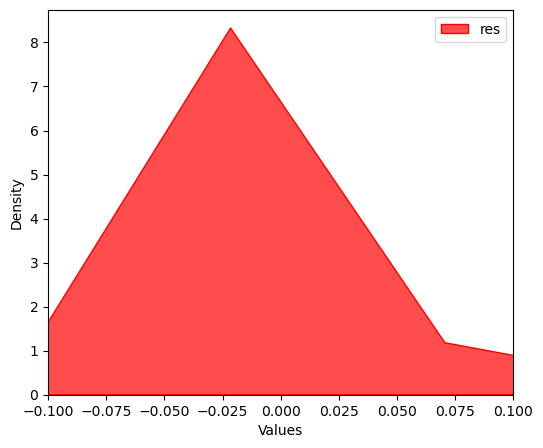

In [86]:
fig = plt.figure(figsize=(6, 5))

sns.kdeplot(grad_dict['res'], fill=True, alpha=0.7, color='red', label='res')

plt.xlabel('Values')
plt.ylabel('Density')
plt.xlim([-0.1, 0.1])
plt.legend()
plt.show()